### This CNN uses three conv-pool blocks, with doubling number of filters used per block. Two dense layers at the end.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, InputLayer
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
import os
root_logdir = os.path.join(os.curdir, "conv_pool_batch_logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [3]:
batch_size = 32
target_size = (512,384)
n_training_images = 2051

train_datagen = ImageDataGenerator(rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.1,
                                  rotation_range=10,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  validation_split=0.15)

test_datagen = ImageDataGenerator(rescale=1./255, 
                                  validation_split=0.15)


train_generator = train_datagen.flow_from_directory('../data/images/train',
                                                    color_mode='rgb',
                                                    target_size=target_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    subset='training')

validation_generator = test_datagen.flow_from_directory('../data/images/train',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical',
                                                       subset='validation')

holdout_generator = test_datagen.flow_from_directory('../data/images/holdout',
                                                       color_mode='rgb',
                                                       target_size=target_size,
                                                       batch_size=batch_size,
                                                       class_mode='categorical')

labels = (train_generator.class_indices)
labels = dict((v, k) for k,v in labels.items())
labels


Found 1937 images belonging to 6 classes.
Found 339 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [10]:
model=Sequential()

model.add(Conv2D(32, (3,3), strides=2, padding='same', input_shape=(target_size[0], target_size[1], 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=3, strides=2))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(6, activation='softmax'))

# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=n_training_images*10//batch_size,
#     decay_rate=0.9)

opt = keras.optimizers.Adam(learning_rate=.001)

model.compile(loss='categorical_crossentropy',
             optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 256, 192, 32)      896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 256, 192, 32)      128       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 127, 95, 32)       0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 127, 95, 64)       18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 47, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 63, 47, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 31, 23, 128)      

In [11]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('conv_pool_batch.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())


history = model.fit(
    train_generator,
    validation_data = validation_generator, 
    verbose=1,
    epochs = 50,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/50
61/61 [==============================] - 184s 3s/step - loss: 2.9764 - accuracy: 0.3163 - val_loss: 1.7668 - val_accuracy: 0.2448
Epoch 2/50
61/61 [==============================] - 191s 3s/step - loss: 1.3334 - accuracy: 0.4644 - val_loss: 1.7528 - val_accuracy: 0.2360
Epoch 3/50
61/61 [==============================] - 198s 3s/step - loss: 1.3018 - accuracy: 0.4971 - val_loss: 1.7969 - val_accuracy: 0.2153
Epoch 4/50
61/61 [==============================] - 197s 3s/step - loss: 1.1823 - accuracy: 0.5653 - val_loss: 1.6275 - val_accuracy: 0.3363
Epoch 5/50
61/61 [==============================] - 196s 3s/step - loss: 1.0402 - accuracy: 0.6010 - val_loss: 1.5641 - val_accuracy: 0.3953
Epoch 6/50
61/61 [==============================] - 198s 3s/step - loss: 1.0427 - accuracy: 0.6168 - val_loss: 1.5673 - val_accuracy: 0.3687
Epoch 7/50
61/61 [==============================] - 199s 3s/step - loss: 0.9801 - accuracy: 0.6358 - val_loss: 1.5839 - val_accuracy: 0.3127
Epoch 8/50
61

In [12]:
score = model.evaluate(holdout_generator, verbose=0)
print('Holdout accuracy:', score[1])

Holdout accuracy: 0.7848605513572693


Holdout accuracy before increasing patience: 0.7968127727508545

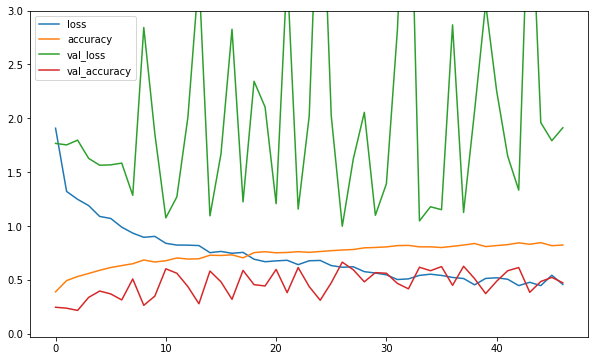

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
[plt.plot(history.history[i], label=i) for i in history.history.keys()]
plt.ylim(top=3)
plt.legend();

In [17]:
max(history.history['val_accuracy'])

0.6637167930603027